In [1]:
import numpy as np
import pandas as pd

import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [2]:
import scipy
import statsmodels
print(np.__version__)
print(pd.__version__)
print(scipy.__version__)
print(statsmodels.__version__)

1.15.4
0.25.2
1.1.0
0.10.1


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Кредитный скоринг

In [4]:
credit_data = pd.read_csv('credit_card_default_analysis.csv', sep = ',', header = 0)

In [5]:
credit_data

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,0,0,0,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


## Задание 1
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [6]:
limit_default = credit_data[credit_data['default']  == 1].LIMIT_BAL
limit_nondefault = credit_data[credit_data['default']  == 0].LIMIT_BAL

In [7]:
limit_nondefault

2         90000
3         50000
4         50000
5         50000
6        500000
          ...  
29990    140000
29992     10000
29993    100000
29995    220000
29996    150000
Name: LIMIT_BAL, Length: 23364, dtype: int64

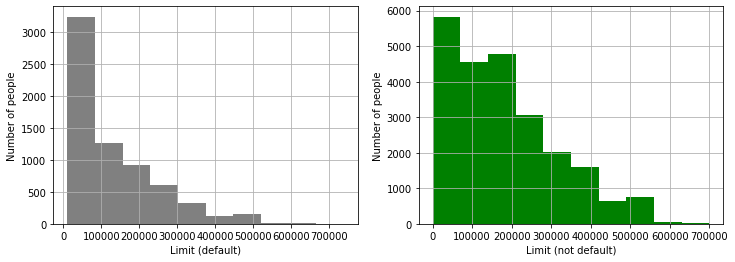

In [155]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(limit_default, color = 'grey')
pylab.xlabel('Limit (default)')
pylab.ylabel('Number of people')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(limit_nondefault, color = 'green', range=(0,700000))
pylab.xlabel('Limit (not default)')
pylab.ylabel('Number of people')

pylab.show()

## Доверительные интервалы на основе bootstrap

## Bootstrap

In [146]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

Построиим 95% доверительные интервалы для медиан

In [150]:
np.random.seed(0)

default_median_scores = list(map(np.median, get_bootstrap_samples(limit_default.values, 1000)))
nondefault_median_scores = list(map(np.median, get_bootstrap_samples(limit_nondefault.values, 1000)))

print("95% confidence interval for the default median limit:",  stat_intervals(default_median_scores, 0.05))
print("95% confidence interval for the nondefault median limit:",  stat_intervals(nondefault_median_scores, 0.05))

95% confidence interval for the default median limit: [80000. 90000.]
95% confidence interval for the nondefault median limit: [150000. 150000.]


Видим, что интервал для медианы кредитного лимита для невернувших левее интервала для вернувших. Гипотеза о равенстве медианных значений кредитного лимита отвергается.

## Двухвыборочный критерий для независимых выборок

### Перестановочный критерий

In [12]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), list(filter(lambda i: i not in index, range(n)))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

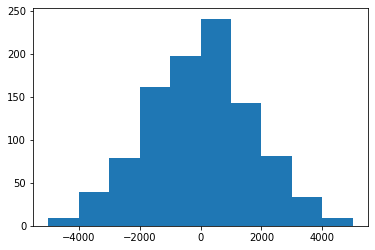

In [13]:
pylab.hist(permutation_zero_dist_ind(limit_default, limit_nondefault, max_combinations = 1000), range=(-5000, 5000))
pylab.show()

Гистограмма нулевого распределения похожа на нормальную, как и требуется для критерия.

In [14]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

Проверим равенство распределений. Нулевая гипотеза состоит в том, что функции распределения для первой и второй выборки одинаковы. Они совпадают. Альтернатива следующая: функция распределения одной выборки получается сдвигом на некоторую дельту из функции распределения на другой выборке.

In [15]:
print("p-value: %f" % permutation_test(limit_default, limit_nondefault, max_permutations = 10000, alternative = 'less'))

p-value: 0.000100


При помощи перестановочного критерия мы можем отвергнуть нулевую гипотезу на уровне значимости 0.05. Т.е. мы можем сказать, что распределения кредитных лимитов в двух группах отличаются статистически значимо. Из графиков распределений видно, что с практической точки зрения распределения тоже значительно отличаются 

## Задание 2
Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [16]:
sex_default = credit_data[credit_data['default']  == 1].SEX
sex_nondefault = credit_data[credit_data['default']  == 0].SEX

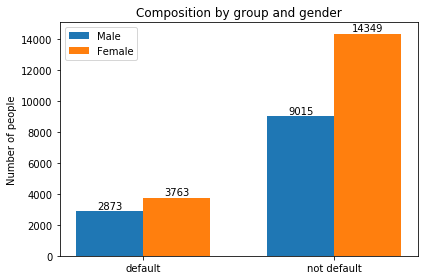

In [17]:
labels = ['default', 'not default']
male = [sex_default[sex_default == 1].shape[0], sex_nondefault[sex_nondefault == 1].shape[0]]
female = [sex_default[sex_default == 2].shape[0], sex_nondefault[sex_nondefault == 2].shape[0]]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, male, width, label='Male')
rects2 = ax.bar(x + width/2, female, width, label='Female')

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_ylabel('Number of people')
ax.set_title('Composition by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()


Для удобства отнормируем значения: 1 и 2 в 0 и 1 соответственно

In [18]:
sex_default_norm = sex_default.to_numpy() - np.ones(sex_default.shape[0])
sex_nondefault_norm = sex_nondefault.to_numpy() - np.ones(sex_nondefault.shape[0])

In [158]:
sex_default_norm

array([1., 1., 0., ..., 0., 0., 0.])

## Интервальные оценки долей

In [20]:
conf_interval_default = proportion_confint(sum(sex_default_norm), 
                                            sex_default_norm.shape[0],
                                            method = 'wilson')
conf_interval_nondefault = proportion_confint(sum(sex_nondefault_norm), 
                                            sex_nondefault.shape[0],
                                            method = 'wilson')

In [21]:
print('interval for defaulted [%f, %f]' % conf_interval_default)
print('interval for not defaulted [%f, %f]' % conf_interval_nondefault)

interval for defaulted [0.555102, 0.578938]
interval for not defaulted [0.607890, 0.620373]


Видим что доверительные интервалы не пересекаются и кажется, что гендерный состав групп вернувших и невернувших кредит отличается: доля женщин среди вернувших больше доли женщин среди невернувших.

## Доверительный интервал для разности долей (независимые выборки)

In [22]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)   
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [23]:
print("confidence interval: [%f, %f]" % proportions_confint_diff_ind(sex_default_norm, sex_nondefault_norm))

confidence interval: [-0.060548, -0.033635]


Доверительный интервал для разности долей снова показывает, что доля женщин среди вернувших больше доли женщин среди невернувших.

## Z-критерий для разности долей (независимые выборки)

In [24]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)
    


Проверим нулевую гипотезу о равенстве долей обоих полов в двух группах заёмщиков против двусторонней альтернативы что доли разные.

In [25]:
print("p-value: %e" % proportions_diff_z_test(proportions_diff_z_stat_ind(sex_default_norm, sex_nondefault_norm)))

p-value: 4.472867e-12


Видим, что на уровне значимости 0.05 мы можем отвергнуть нулевую гипотезу о равенстве долей. 

Теперь проверим нулевую гипотезу о равенстве долей обоих полов в двух группах заёмщиков против односторонней альтернативы что доля женщин среди вернувших больше доли женщин среди невернувших.

In [26]:
print("p-value: %e" % proportions_diff_z_test(proportions_diff_z_stat_ind(sex_default_norm, sex_nondefault_norm), 'less'))

p-value: 2.236402e-12


На уровне значимости 0.05 нулевая гипотеза против этой односторонней альтернативы также отвергается. Доля женщин среди вернувших кредит действительно больше доли женщин среди невернувших.

## Задание 3
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ?


In [27]:
edu_default = credit_data[credit_data['default']  == 1].EDUCATION
edu_nondefault = credit_data[credit_data['default']  == 0].EDUCATION

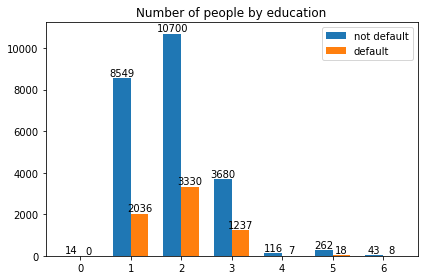

In [91]:
labels = ['0', '1', '2', '3', '4', '5', '6']
nondefault = raw_crosstab[0].to_numpy()
default = raw_crosstab[1].to_numpy()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, nondefault, width, label='not default')
rects2 = ax.bar(x + width/2, default, width, label='default')

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_ylabel('Scores')
ax.set_title('Number of people by education')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

Составим таблицу сопряженности "образование" на "возврат долга" только по наблюдаемым данным

In [52]:
raw_crosstab = pd.crosstab(credit_data['EDUCATION'], credit_data['default'])

In [40]:
raw_crosstab

default,0,1
EDUCATION,,
0,14,0
1,8549,2036
2,10700,3330
3,3680,1237
4,116,7
5,262,18
6,43,8


Составим таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Под ожидаемым подразумеваем, что во всех группах по образованию доля не вернувших долг равна средней по всем группам по образованию

In [54]:
crosstab = raw_crosstab.copy()

In [53]:
expected_default = []
expected_nondefault = []
for i in range(7):
    expected_nondefault.append(int(round((1-credit_data['default'].mean())*raw_crosstab.iloc[i].sum())))
    expected_default.append(raw_crosstab.iloc[i].sum()-expected_nondefault[i])

In [55]:
crosstab[0] = raw_crosstab[0] - expected_nondefault
crosstab[1] = raw_crosstab[1] - expected_default

In [85]:
crosstab

default,0,1
EDUCATION,,
0,3,-3
1,305,-305
2,-227,227
3,-149,149
4,20,-20
5,44,-44
6,3,-3


Приведём значения ячеек к одному масштабу:

Заменим значения разностей наблюдаемых значений с ожидаемыми на доли, на которые наблюдаемые значения в каждой ячейке таблицы сопряжённости отличаются от ожидаемых.

In [77]:
crosstab_modified = crosstab.copy()

In [78]:
crosstab_modified[0] = pd.to_numeric(crosstab_modified[0], downcast='float')
crosstab_modified[1] = pd.to_numeric(crosstab_modified[1], downcast='float')

In [83]:
for i in range(7):
    crosstab_modified[0][i] = crosstab_modified[0][i]/(expected_nondefault[i])
    crosstab_modified[1][i] = crosstab_modified[1][i]/(expected_default[i])

In [84]:
crosstab_modified

default,0,1
EDUCATION,,
0,0.272727,-1.000000
1,0.036997,-0.130286
2,-0.020774,0.073155
3,-0.038914,0.136949
4,0.208333,-0.740741
5,0.201835,-0.709677
6,0.075000,-0.272727


Как видим, докторская степень является наилучшим индикатором того, что человек отдаст долг. Наилучшим индикатором того, что человек НЕ отдаст долг является уровень образования "выпускник школы"

### Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг.

Проверим нулевую гипотезу о том, что между EDUCATION и default связи нет, то есть они независимы, против общей альтернативы, то есть нулевая гипотеза не верна, какая-то связь есть. Сделаем это с помощью критерия хи-квадрат.

Для применения критерия хи-квадрат нужно, чтобы выборки были достаточно большими, нужно, чтобы у вас было не менее 40 объектов, и кроме того, нужно, чтобы ожидаемое количество элементов в каждой ячейке таблицы было меньше 5, не более чем в 20 % ячеек. Объектов у нас больше 40. Проверим второе условие

In [201]:
counter = 0
for i in range(raw_crosstab.shape[0]):
    for j in range(raw_crosstab.shape[1]):
        if raw_crosstab.values[i][j] < 5:
            counter = counter + 1
print (counter/14)

0.07142857142857142


Критерий хи-квадрат применим

In [192]:
from scipy.stats import chi2_contingency
chi2_contingency(raw_crosstab)

(163.21655786997073,
 1.2332626245415605e-32,
 6,
 array([[1.0903200e+01, 3.0968000e+00],
        [8.2435980e+03, 2.3414020e+03],
        [1.0926564e+04, 3.1034360e+03],
        [3.8293596e+03, 1.0876404e+03],
        [9.5792400e+01, 2.7207600e+01],
        [2.1806400e+02, 6.1936000e+01],
        [3.9718800e+01, 1.1281200e+01]]))

In [194]:
print("p-value: %e" % chi2_contingency(raw_crosstab)[1])

p-value: 1.233263e-32


На уровне значимости 0.05 нулевая гипотеза отвергается. ОБразование влияет на то, вернёт ли человек долг.

## Задание 4
Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

Для начала рассмотрим таблицу сопряженности семейного положения и индикатора дефолта.

In [202]:
marriage_crosstab = pd.crosstab(credit_data['MARRIAGE'], credit_data['default'])

In [203]:
marriage_crosstab

default,0,1
MARRIAGE,,
0,49,5
1,10453,3206
2,12623,3341
3,239,84


Для применения критерия хи-квадрат нужно, чтобы выборки были достаточно большими, нужно, чтобы у вас было не менее 40 объектов, и кроме того, нужно, чтобы ожидаемое количество элементов в каждой ячейке таблицы было меньше 5, не более чем в 20 % ячеек. Очевидно это выполняется. 


На основания таблицы сопряженности можно посчитать меру взаимосвзяи между признаками - коэффицент V Крамера.

In [210]:
np.sqrt(chi2_contingency(marriage_crosstab)[0]/(marriage_crosstab.sum().sum() * (min(marriage_crosstab.shape)-1)))

0.034478203662766466

Коэффицент V Крамера близок к нулю, т.е. взаимосвязь между признаками есть, но слабая.

Проверим нулевую гипотезу о том, что между MARRIAGE и default связи нет, то есть они независимы, против общей альтернативы, то есть нулевая гипотеза не верна, какая-то связь есть. Сделаем это с помощью критерия хи-квадрат.



In [209]:
print("p-value: %e" % chi2_contingency(marriage_crosstab)[1])

p-value: 8.825862e-08


На уровне значимости 0.05 нулевая гипотеза отвергается. Семейный статус влияет на то, вернёт ли человек долг, но как показал коэффициент V Крамера влияет слабо.

## Задание 5
Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [129]:
age_default = credit_data[credit_data['default']  == 1].AGE
age_nondefault = credit_data[credit_data['default']  == 0].AGE

In [211]:
age_default

0        24
1        26
13       30
16       24
21       39
         ..
29991    34
29994    34
29997    37
29998    41
29999    46
Name: AGE, Length: 6636, dtype: int64

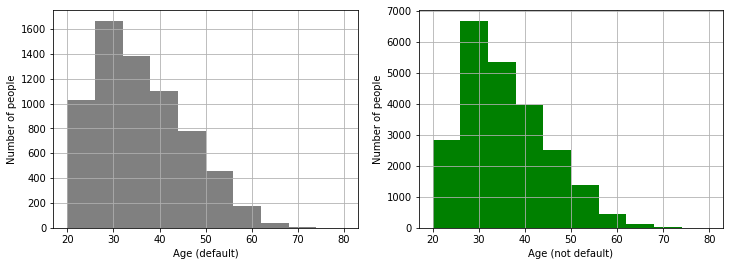

In [143]:
pylab.figure(figsize=(12,4))

pylab.subplot(1,2,1)
pylab.grid()
pylab.hist(age_default, color = 'grey', range=(20,80))
pylab.xlabel('Age (default)')
pylab.ylabel('Number of people')

pylab.subplot(1,2,2)
pylab.grid()
pylab.hist(age_nondefault, color = 'green', range=(20,80))
pylab.xlabel('Age (not default)')
pylab.ylabel('Number of people')

pylab.show()

Проверим нулевую гипотезу о равенстве медианных значений возрастов людей против общей альтернативы

### Доверительные интервалы на основе bootstrap

In [181]:
np.random.seed(0)

default_median_age = list(map(np.median, get_bootstrap_samples(age_default.values, 1000)))
nondefault_median_age = list(map(np.median, get_bootstrap_samples(age_nondefault.values, 1000)))

print("95% confidence interval for the default median limit:",  stat_intervals(default_median_age, 0.05))
print("95% confidence interval for the nondefault median limit:",  stat_intervals(nondefault_median_age, 0.05))

95% confidence interval for the default median limit: [34. 35.]
95% confidence interval for the nondefault median limit: [34. 34.]


In [182]:
delta_median_age = list(map(lambda x: x[1] - x[0], zip(default_median_age, nondefault_median_age)))

In [189]:
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_age, 0.05))

95% confidence interval for the difference between medians [-1.  0.]


0 входит в доверительный интервал разности медиан и поэтому на уровне значимости 0.05 мы принимаем нулевую гипотезу о равенстве медианных значений возрастов людей

Проверим равенство распределений. Нулевая гипотеза состоит в том, что функции распределения для первой и второй выборки одинаковы. Они совпадают. Альтернатива следующая: функция распределения одной выборки получается сдвигом на некоторую дельту из функции распределения на другой выборке.

### Перестановочный критерий

In [142]:
print("p-value: %f" % permutation_test(age_default, age_nondefault, max_permutations = 1000))

p-value: 0.015000


На уровне значимости 0.05 мы можем отвергнуть нулевую гипотезу. Распределения двух групп заёмщиков по возрастам отличаются статистически значимо, но с практической точки зрения отличия незначительны.